## 2. Sensors / Signal Acquisition

Scenario: Multiple experts have been asked, how they would choose the parameters / what they believe are the ranges of the parameters:

#### Placement of Sensors
- $n_\mathrm{sen} = $ Number of sensors max. 12 channels
- $\operatorname{loc}_\mathrm{sen} = 0.2:[\mathrm{lumped}];0.8:[\mathrm{distributed}]$ Placement of sensors (evenly distributed, every five meters, distance between sensors min. 20 meters; both directions simultaneously!)

#### Type of Sensors
- $q_\mathrm{sen} = 0.8[\mathrm{a}];0.2[\mathrm{v}]$ Measurement quantity (acceleration, velocity)
- $\operatorname{SNR}_\mathrm{sen} = $ Sensor noise variance (pre-sampling, white noise)<br>
**TODO: The datasheets of different sensors should be examined, to obtain reasonable values for these parameters. PCB 393A01, PCB 393B31, Gyralp GMC 40, Lennarts**

#### Signal acqusition system
- Broadband Resolution
    - $q = $ Quantization range. <br>
    **TODO: Usually set on the basis of preliminary measurements. Provide an example signal to given knowledge, and then range x 2 ... 10 and round to a voltage level**
    - $b = [0.05:12, 0.5:16, 0.3:24, 0.05:32]$ Number of quantization bits (**TODO: allow discrete ranges? e.g. 12,16,24,32)**
- Aliasing Filter (FIR: Windowed Sinc)
    - $f_c = $ Filter 3 dB cutoff frequency 2...2.5
    - $w_\mathrm{type}[m]$ Window type  **TODO: Which window types to include (rectangular, hanning, hamming, etc.)?**
    - $M = $ Window length
- $f_s = $ Sample rate $f_s = \frac{1}{\Delta t}$
- $N = $ Number of Timesteps / Measurement Duration $T = N \Delta t$
- $\operatorname{SNR}_\mathrm{acq} = $ Acquisition system noise variance (post-sampling, white noise) <br>
  **TODO: Where to get reasonable values? from Datasheets**
- **TODO: model the built-in highpass filter**

#### Outputs
- Total SNR
- Effective quantization bits [Channel average] (Considering range, bits and actual vibration level)
- **TODO: Estimated SNR**

In [43]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
# dont forget to forward ports: ssh -L 8080:127.0.0.1:8080 sima9999@makalu47.rz.tu-ilmenau.de

import sys
import os
sys.path.append("/home/sima9999/code/")
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from model.mechanical import Mechanical, MechanicalDummy
from model.acquisition import Acquire

%aimport -sys -logging -matplotlib -matplotlib.pyplot -numpy -pandas - scipy.stats -scipy.stats.qmc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


## Parameters

In [44]:
'''
Continue:

estimate incompleteness on any output e.g. RMS_a(TMD_y)


Read, understand and connect model.acquisition.Acquire class with model.mechanical.Mechanical
implement helper to generate channel definitions
implement method apply_sensor
Get frequency responses of sensors
get SNR of sensors
'''

'\nContinue:\n\nestimate incompleteness on any output e.g. RMS_a(TMD_y)\n\n\nRead, understand and connect model.acquisition.Acquire class with model.mechanical.Mechanical\nimplement helper to generate channel definitions\nimplement method apply_sensor\nGet frequency responses of sensors\nget SNR of sensors\n'

## Structural Model generation

INFO:model.mechanical:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_oma_a/samples/mechanical.npz


Text(0, 0.5, 'Modal damping ratio [%]')

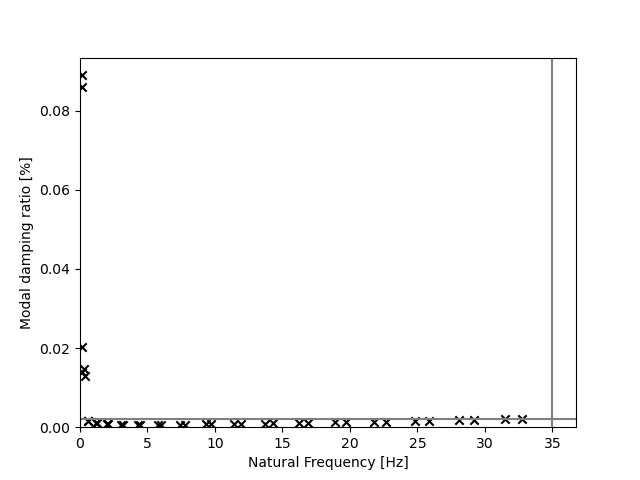

In [49]:
from model.mechanical import Mechanical, MechanicalDummy

if os.path.split(result_dir)[-1] != 'samples':
    result_dir=result_dir / 'samples'

jid = 'd3f294e6_e3f6077f'

zeta = 0.002 # normal damping
# zeta = 0.0005 # light damping
# zeta = 0.005 # heavy damping
Iy = 0.01196
Iz = 0.01304
alpha = 45

fs_m = 70
duration = 2**19/fs_m

v_b = 25.0
skip_existing = True

if not isinstance(result_dir, Path):
    result_dir = Path(result_dir)

if not isinstance(working_dir, Path):
    working_dir = Path(working_dir)

# Set up directories
if '_' in jid:
    id_ale, id_epi = jid.split('_')
    this_result_dir = result_dir / id_ale
    if not os.path.exists(this_result_dir):
        os.makedirs(this_result_dir)

    this_result_dir = this_result_dir / id_epi
    if not os.path.exists(this_result_dir):
        os.makedirs(this_result_dir)
else:
    this_result_dir = result_dir / jid
    if not os.path.exists(this_result_dir):
        os.makedirs(this_result_dir)


seed = int.from_bytes(bytes(jid, 'utf-8'), 'big')
        
# assemble structural parameters
struct_parms = {
        'L'         : 200,

        'E'         : 2.1e11,
        'A'         : 0.03287,

        'x_knl'     : 160,

        'm_tmd'     : 800,
        'ky_tmd'    : 1025.48,
        'kz_tmd'    : 1025.48,
        'dy_tmd'    : 200,
        'dz_tmd'    : 200,
        'x_tmd'     : 200,
        }

# Cross-section
Iyz = 0
# rotate cross section about angle alpha
alpha = alpha * 2 * np.pi / 360
struct_parms['Iy'] = 0.5 * (Iy + Iz) + 0.5 * (Iy - Iz) * np.cos(2 * alpha) + Iyz * np.sin(2 * alpha)
struct_parms['Iz'] = 0.5 * (Iy + Iz) - 0.5 * (Iy - Iz) * np.cos(2 * alpha) - Iyz * np.sin(2 * alpha)
struct_parms['Iyz'] = -0.5 * (Iy - Iz) * np.sin(2 * alpha) + Iyz * np.cos(2 * alpha)

# equivalent spring stiffness of guy cables
A_wire = 0.00075
rho = 7850
N_wire = 60000
Aeq = A_wire/(1 + (A_wire * rho * 9.819 * 70 / N_wire)**2 * struct_parms['E'] * A_wire / 12 / N_wire)
keq = (struct_parms['E'] * Aeq * (70**2 / (70**2 + 160**2)) + N_wire) / np.sqrt(70**2 + 160**2)
struct_parms['kz_nl'] = 1.7 * keq
struct_parms['ky_nl'] = 2 * keq

# additional mass into mass density
add_mass = 60
struct_parms['rho'] = rho + add_mass / struct_parms['A']

# model parameters
num_nodes = 201
num_modes = 38 # ensure max(f) is below nyquist frequency to avoid wrap-around in the frf

# load or build structural model
mech = None
if skip_existing and os.path.exists(result_dir / f'mechanical.npz'):
    try:
        mech = MechanicalDummy.load(fpath=result_dir / f'mechanical.npz')
        assert mech.struct_parms['Iy'] == struct_parms['Iy']
        assert mech.struct_parms['Iz'] == struct_parms['Iz']
        assert mech.struct_parms['Iyz'] == struct_parms['Iyz']
        assert mech.damping == zeta
        assert mech.omegas is not None
        assert mech.frf is not None
    except Exception as e:
        mech = None
        raise e

if mech is None:
    global ansys
    if 'ansys' not in globals():
        ansys = Mechanical.start_ansys(working_dir=working_dir, jid=jid)
    mech = Mechanical(ansys=ansys, jobname=jid, wdir=working_dir)
    mech.build_conti(struct_parms, 
                     Ldiv=num_nodes, damping=zeta, 
                     num_modes=num_modes)

f,d,phi = mech.modal()

plt.figure()
plt.axhline(zeta, color='grey')
plt.axvline(fs_m/2, color='grey')
plt.scatter(f,d,  marker='x', color='k')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Natural Frequency [Hz]')
plt.ylabel('Modal damping ratio [%]')
# plt.yscale('log')

## Windfield generation

## Transient Solution

In [50]:
%%time
if os.path.exists(this_result_dir / 'response.npz') and skip_existing:
    arr = np.load(this_result_dir / 'response.npz')
    t_vals = arr['t_vals']
    d_freq_time = arr['d_freq_time']
    v_freq_time = arr['v_freq_time']
    a_freq_time = arr['a_freq_time']
else:
    t_vals, response = mech.transient_ifrf(Fu_time, Fv_time,
                                           mech.nodes_coordinates[0:-2,0],
                                           inp_dt = 1 / fs_m)

    [d_freq_time, v_freq_time, a_freq_time] = response       
    # FRF was not pre-computed: save, clear and exit
    if isinstance(mech, Mechanical):
        print('save')
        mech.save(os.path.join(result_dir, 'mechanical.npz'))
        ansys.finish()
        ansys.cwd('/dev/shm/womo1998/')
        ansys.clear()
    
    np.savez(this_result_dir / 'response.npz', 
             t_vals=t_vals, 
             d_freq_time=d_freq_time, 
             v_freq_time=v_freq_time, 
             a_freq_time=a_freq_time)
    print(this_result_dir / 'response.npz')

# zeros = np.zeros((N_m, 1))
# t, [d_time, v_time, a_time] = mech.transient(fy=np.hstack((Fu_time, zeros, zeros)), 
#                                              fz=np.hstack((Fv_time, zeros, zeros)), 
#                                              deltat=1 / fs_m, timesteps=N_m)
# # remove DOF x
# d_time = d_time[:,:,1:]
# v_time = v_time[:,:,1:]
# a_time = a_time[:,:,1:]

CPU times: user 5.75 s, sys: 3.16 s, total: 8.92 s
Wall time: 11.3 s


(<Figure size 640x480 with 3 Axes>,
 <Figure size 640x480 with 3 Axes>,
 <Figure size 640x480 with 3 Axes>)

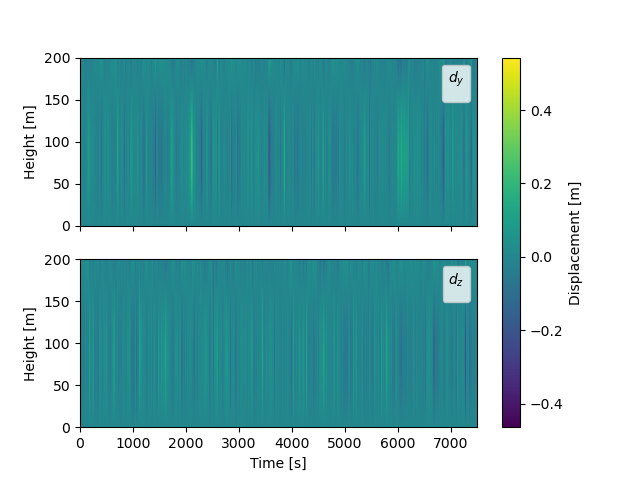

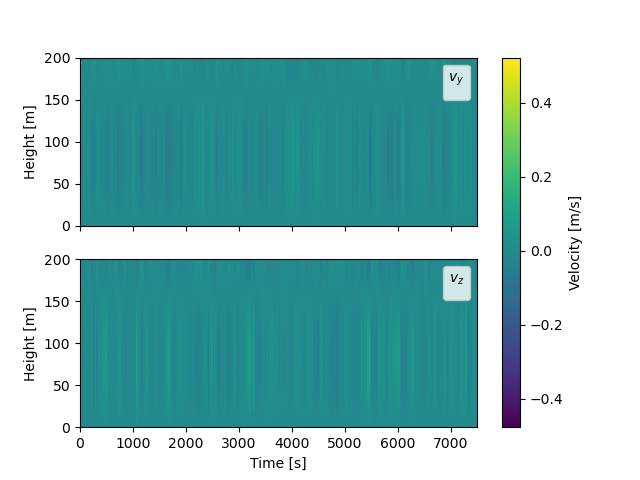

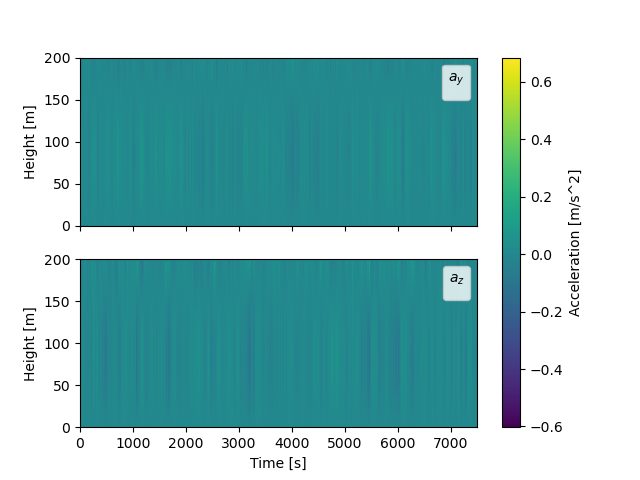

In [51]:
plot_response_field(d_freq_time, v_freq_time, a_freq_time, duration, height=200)

In [56]:
mech.t_vals_amb = t_vals
mech.resp_hist_amb = [d_freq_time, v_freq_time, a_freq_time]
mech.state[2] = True

In [56]:
acqui = Acquire.init_from_mech(mech)

INFO:model.acquisition:Initializing Acquire object from a Mechanical object


IndexError: index 2 is out of bounds for axis 2 with size 2

In [55]:
a_freq_time.shape

(524288, 203, 2)